In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import os
import glob
from PIL import Image
from numpy import expand_dims

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D,BatchNormalization
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.utils import np_utils
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import img_to_array

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

from sklearn.metrics import accuracy_score

In [ ]:
train_csv_dir = "/content/drive/MyDrive/Colab Notebooks/ML_Project/Nature/Nature_Training_Set.csv"
test_csv_dir = "/content/drive/MyDrive/Colab Notebooks/ML_Project/Nature/Nature_Test_Set.csv"

In [ ]:
img_dir = "/content/drive/MyDrive/Colab Notebooks/ML_Project/Nature/Train Files"
EPOCHS = 30
batchSize = 32
img_Size = 256

In [ ]:
def append_ext(fn):
    return fn+".jpg"

train_data = pd.read_csv(train_csv_dir,dtype=str)
train_data["FileName"] = train_data["FileName"].apply(append_ext)
train_data['Label'] = train_data['Label'].astype(str)
Y = train_data[['Label']]

print(train_data.shape)
train_data.head()

(15000, 2)


,FileName,Label
0,93010081.jpg,35
1,11777641.jpg,9
2,7154596.jpg,16
3,91921382.jpg,21
4,62681224.jpg,11


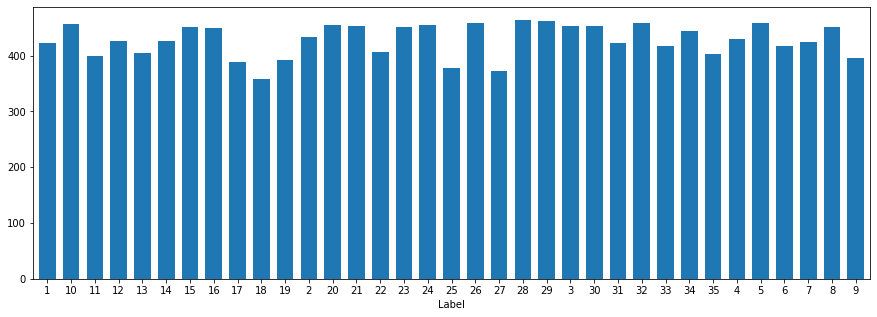

In [ ]:
train_data.groupby('Label')["FileName"].count().plot(kind='bar', figsize = (15, 5), rot=0, width = 0.7)

In [ ]:
train_df, validate_df = train_test_split(train_data, test_size=0.10, random_state=42)

train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 15, shear_range = 0.2,
                                zoom_range=0.2, horizontal_flip = True
                                ,width_shift_range = 0.1, height_shift_range = 0.1)

validation_datagen = ImageDataGenerator(rescale=1./255)

print(len(train_df), "----------", len(validate_df))

13500 ---------- 1500


In [ ]:
train_generator = train_datagen.flow_from_dataframe(dataframe = train_df, directory = img_dir, x_col = "FileName",
                    y_col = "Label", batch_size = batchSize,  
                    class_mode="categorical", target_size= (img_Size, img_Size))

Found 13500 validated image filenames belonging to 35 classes.


In [ ]:
valid_generator = validation_datagen.flow_from_dataframe(dataframe = validate_df, directory = img_dir, x_col = "FileName",
                    y_col = "Label", batch_size = batchSize,
                    class_mode="categorical", target_size = (img_Size, img_Size))

Found 1500 validated image filenames belonging to 35 classes.


# **Image Augmentation**

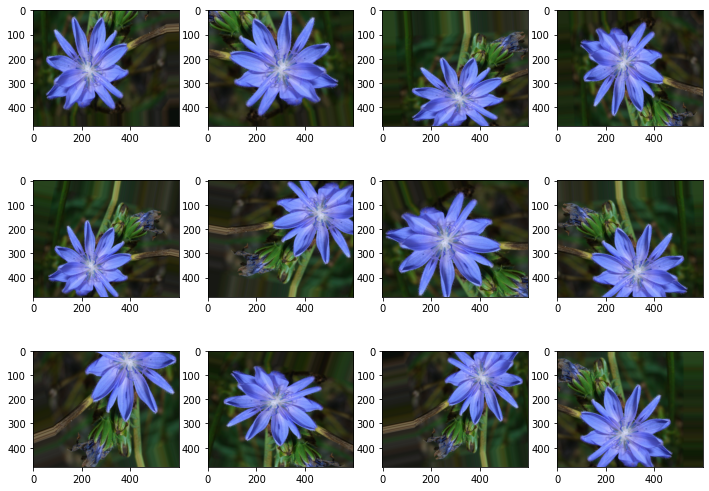

In [ ]:
# example of image augmentation
img = Image.open(img_dir + "//" + "47632287.jpg")
data = img_to_array(img)
samples = expand_dims(data, 0)
#52989471
datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.20, width_shift_range=0.15, height_shift_range=0.15, 
                                 shear_range=0.15, horizontal_flip=True, vertical_flip = True)
it = datagen.flow(samples, batch_size = 32)
plt.figure(figsize=(12,12))
for i in range(12):
    #plt.subplot(330 + 1 + i)
    plt.subplot(4,4,i+1)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
    #plt.axis('off')
plt.show()

# **Pre-trained Model VGG16**

In [ ]:
# Init the VGG model
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(img_Size, img_Size, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Create the model
model = Sequential()
# Add the vgg convolutional base model
model.add(vgg_conv)
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_df["Label"].unique()), activation='softmax'))

# Configure the model for training
model.compile(loss='categorical_crossentropy',    optimizer= tf.keras.optimizers.RMSprop(learning_rate=1e-4),  metrics=['accuracy'])

train_steps = train_generator.n//train_generator.batch_size
validation_steps = valid_generator.n//valid_generator.batch_size

mc = ModelCheckpoint(filepath= "./best_model_vgg16.h5", monitor="val_accuracy", verbose=1, save_best_only=True)

# Train the model
history = model.fit(train_generator, steps_per_epoch = train_steps, epochs = 50,
                              validation_data = valid_generator, validation_steps = validation_steps, callbacks = mc)

Epoch 1/30
421/421 [==============================] - ETA: 0s - loss: 2.4289 - accuracy: 0.3426 
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to ./best_model_vgg16.h5
421/421 [==============================] - 10264s 24s/step - loss: 2.4289 - accuracy: 0.3426 - val_loss: 1.5303 - val_accuracy: 0.5625
Epoch 2/30
421/421 [==============================] - ETA: 0s - loss: 1.6241 - accuracy: 0.5398
Epoch 2: val_accuracy improved from 0.56250 to 0.67391, saving model to ./best_model_vgg16.h5
421/421 [==============================] - 261s 619ms/step - loss: 1.6241 - accuracy: 0.5398 - val_loss: 1.1821 - val_accuracy: 0.6739
Epoch 3/30
421/421 [==============================] - ETA: 0s - loss: 1.3637 - accuracy: 0.6068
Epoch 3: val_accuracy improved from 0.67391 to 0.70177, saving model to ./best_model_vgg16.h5
421/421 [==============================] - 261s 620ms/step - loss: 1.3637 - accuracy: 0.6068 - val_loss: 1.0859 - val_accuracy: 0.7018
Epoch 4/30
421/421 [=======

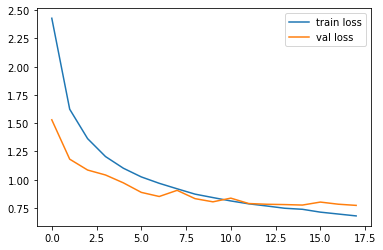

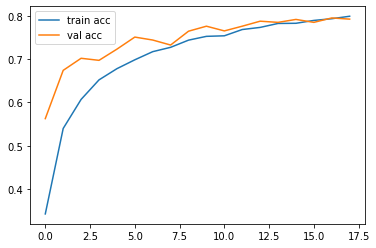

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

# **Loading saved model**

In [ ]:
nature_saved_model = load_model("/content/drive/MyDrive/Colab Notebooks/ML_Project/Nature/best_model_vgg1_79484.h5")

In [ ]:
test_img_dir = "/content/drive/MyDrive/Colab Notebooks/ML_Project/Nature/Nature Test Image Files"

In [ ]:
test_df = pd.read_csv(test_csv_dir,dtype=str)
test_df["FileName"] = test_df["FileName"].apply(append_ext)

print(test_df.shape)
test_df.head()

(1526, 2)


,FileName,Label
0,51306401.jpg,NaN
1,67968696.jpg,NaN
2,23128722.jpg,NaN
3,49893925.jpg,NaN
4,53534042.jpg,NaN


In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_set = test_gen.flow_from_dataframe(dataframe = test_df, directory = test_img_dir,
                                                x_col="FileName",y_col=None,
                                                 class_mode=None, shuffle=False,
                                                 target_size=(img_Size, img_Size))

Found 1526 validated image filenames.


In [ ]:
print(len(train_generator.class_indices.items()), "\n")
print(train_generator.class_indices.items())

35 

dict_items([('1', 0), ('10', 1), ('11', 2), ('12', 3), ('13', 4), ('14', 5), ('15', 6), ('16', 7), ('17', 8), ('18', 9), ('19', 10), ('2', 11), ('20', 12), ('21', 13), ('22', 14), ('23', 15), ('24', 16), ('25', 17), ('26', 18), ('27', 19), ('28', 20), ('29', 21), ('3', 22), ('30', 23), ('31', 24), ('32', 25), ('33', 26), ('34', 27), ('35', 28), ('4', 29), ('5', 30), ('6', 31), ('7', 32), ('8', 33), ('9', 34)])


In [ ]:
pred = nature_saved_model.predict(test_set)
predicted_class_indices=np.argmax(pred,axis=1)
print(predicted_class_indices,"\n")

labels2=dict((v,k) for k,v in train_generator.class_indices.items())
print(labels2)
predictions=[labels2[k] for k in predicted_class_indices]
print("\n", len(predictions))

[ 1 15 18 ... 11 34 10] 

{0: '1', 1: '10', 2: '11', 3: '12', 4: '13', 5: '14', 6: '15', 7: '16', 8: '17', 9: '18', 10: '19', 11: '2', 12: '20', 13: '21', 14: '22', 15: '23', 16: '24', 17: '25', 18: '26', 19: '27', 20: '28', 21: '29', 22: '3', 23: '30', 24: '31', 25: '32', 26: '33', 27: '34', 28: '35', 29: '4', 30: '5', 31: '6', 32: '7', 33: '8', 34: '9'}

 1526


In [ ]:
test_df["Label"] = predictions
test_df.head()

,FileName,Label
0,51306401.jpg,10
1,67968696.jpg,23
2,23128722.jpg,26
3,49893925.jpg,17
4,53534042.jpg,14


In [ ]:
test_df_csv = test_df["Label"] 
test_df_csv.head()

0    10
1    23
2    26
3    17
4    14
Name: Label, dtype: object

In [ ]:
test_df_csv.to_csv('N.csv',index=False)
print("output csv created")

output csv created


In [ ]:
test_x =[]
for i in test_df[0:10].FileName:
    img = Image.open(test_img_dir + "//" + i)
    img = img.resize((256, 256))
    img = img.convert("RGB")
    test_x.append(np.array(img))

test_y = np.array(test_df[0:10].Label)
test_x = np.array(test_x)
print(test_x.shape)
print(test_y.shape)

xtest = test_x/255
ytest = keras.utils.np_utils.to_categorical(test_y)

(10, 256, 256, 3)
(10,)


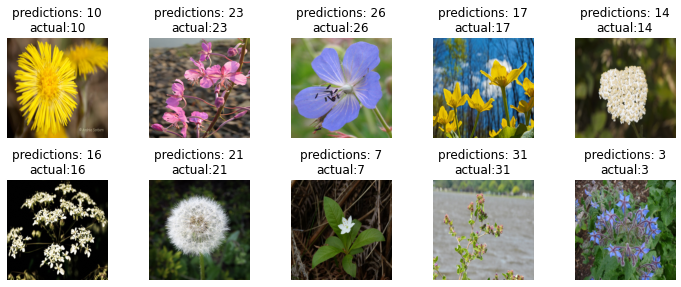

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(10):
    ax = plt.subplot(5,5,i+1)
    ax.imshow(xtest[i])
    ax.set_title(f'predictions: {predictions[i]}\nactual:{test_y[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# **Model Evaluation**

In [ ]:
test_prediction = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML_Project/Nature/N.csv")
prof_prediction = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML_Project/Nature/YtestN.csv")

In [ ]:
print('Topic Accuracy for Nature Project = %s' % accuracy_score(test_prediction, prof_prediction))

Topic Accuracy for Nature Project = 0.8034076015727392
